In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
class ConditionProjection(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    
    def forward(self, x):
        data, condition = x
        return torch.cat([data, self.f(condition)], dim=1)

In [4]:
p = builder([
    nn.Linear(10, 512),
    nn.ReLU(),
    nn.Linear(512, 784),
    layer.Reshape((-1, 1, 28, 28))
])

In [13]:
g = builder([
    nn.Linear(110, 8*4*4),
    layer.Reshape((-1, 8, 4, 4)),
    AutoConvTransposeNet2d(8, 3),
    nn.Conv2d(256, 128, 3),
    nn.BatchNorm2d(128),
    nn.ELU(),
    nn.Conv2d(128, 1, 3),
    nn.Sigmoid()
])  

In [14]:
d = builder([
#     ConditionProjection(p),
    AutoConvNet2d(1, 4),
    Auxiliary(builder([
        nn.Linear(512, 10),
        nn.LogSoftmax(-1)
    ])),
    nn.Linear(512, 1),
    nn.Sigmoid(),
])

In [15]:
train_loader = VisionDataset(vision.MNIST, batch_size=32, train=True, normalize=False)

In [17]:
runner = Runner(GANModel(g, d, condition_vector=[10, None], condition_onehot=True), train_loader, None, 'rmsprop', GANLoss('vanilla', aux_loss=F.nll_loss))

In [18]:
runner.init_model('orthogonal')

In [19]:
runner.fit(10)

  Epochs   train_d_loss  train_g_loss 
    1         2.0366        3.4075    


    2         0.8633        1.9855    


    3         0.7219        2.5379    


    4         0.6232        2.5991    


    5         0.5443        3.1393    


    6         0.4732        3.3047    


    7         0.4428        3.7949    


    8         0.4012        3.7731    


    9         0.4522        3.7724    


    10        0.4036        3.8442    


In [23]:
condition = torch.from_numpy(np.array(list(range(10)))).cuda().float()
img = runner.model.sample(10, condition_data=condition)

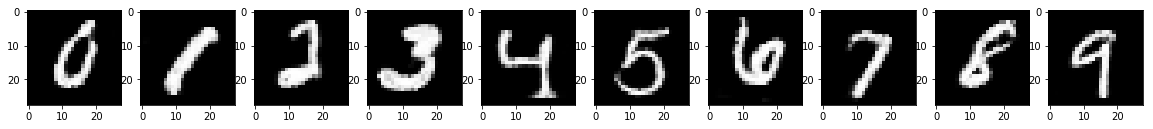

In [24]:
import matplotlib.pyplot as plt
fig, arr = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    arr[i].imshow(img[i][0].detach().cpu().numpy(), cmap='gray')
plt.show()

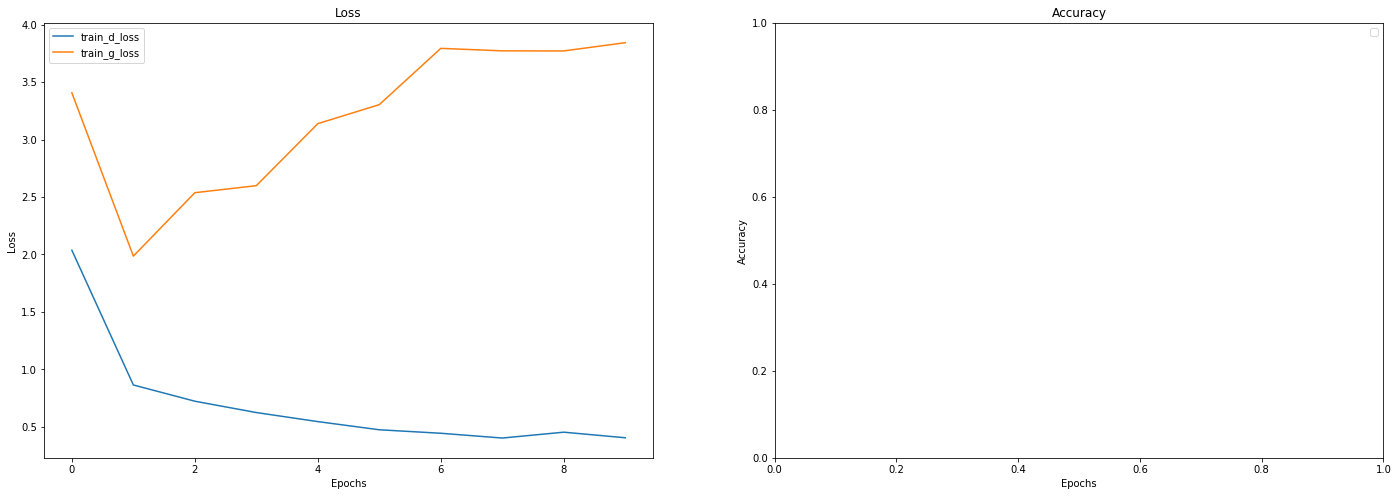

In [22]:
runner.history()